In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import gym
import random
import logging
import random
import warnings
import tensorflow as tf
import keras
from collections import deque
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
minmax = MinMaxScaler()

In [2]:
#Disable the Warning from Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.get_logger().setLevel('ERROR')
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [3]:
#Getting current working directory
dir_path = os.getcwd()
dataset = 'train_FD002.csv'
#importing data into df
df = pd.read_csv(dir_path + r'/' + dataset, sep=",", skipinitialspace=True).dropna(axis=1)

#Data separation
df_A = df[df.columns[[0, 1]]]
df_W = df[df.columns[list(range(2,5))]]
df_S = df[df.columns[list(range(5,26))]]
df_X = pd.concat([df_W, df_S], axis=1)

#Data normalization
minmax = MinMaxScaler()
df_X = minmax.fit_transform(df_X)

engine_unit = 1

In [4]:
#Failure penalty
c_f = -100
#Repair penalty
c_r = -50
do_nothing = 0
policy = {}
policy_test = {}

In [5]:
def create_sequences(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        xs.append(x)
    return np.array(xs)

seq_length = 50  # Example sequence length
X = create_sequences(df_X, seq_length)

# Expand dimensions to match the input shape of Conv1D
X = np.expand_dims(X, axis=2)
df_X = np.reshape(X, (X.shape[0], X.shape[1],24))

In [6]:
class CustomEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, is_training=True, verbose=True):
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(df_X.shape[1],))
        self.action_space = gym.spaces.Discrete(2)
        self.reward = 0
        self.cycle = 0
        self.done = False
        self.engine_unit = engine_unit
        self.engine_df_A = df_A[df_A['unit'] == self.engine_unit]
        self.X = df_X[self.engine_df_A.index[0]:self.engine_df_A.index[-1] + 1 ]
        self.state = self.X[self.cycle]
        self.failure_state = self.engine_df_A['cycle'].max() - 1
        self.train = is_training
        self.verbose = verbose

    def get_next_engine_data(self):
        self.engine_unit += 1

        if self.train:
            #training
            if self.engine_unit > int((df_A['unit'].max() * 80 / 100)):
                self.engine_unit = 1
        else:
            #testing
            if self.engine_unit > df_A['unit'].max():
                self.engine_unit = int((df_A['unit'].max() * 80 / 100) + 1)

        if self.verbose:
            print("********|engine unit|********:", self.engine_unit)
            
        self.engine_df_A = df_A[df_A['unit'] == self.engine_unit]
        self.X = df_X[self.engine_df_A.index[0]:self.engine_df_A.index[-1]+ 1]
        self.failure_state = self.engine_df_A['cycle'].max() - 1
        return self.X

    def step(self, action):
        
        # Action 0 represents do nothing
        if action == 0:
            #if self.verbose:
            #   print("|hold|:", self.cycle)
            if self.cycle == self.failure_state:
                self.reward = (c_f)
                self.state = self.X[self.cycle]
                self.done = True
                if self.train: # training policy
                    if (self.engine_unit not in policy or (self.cycle > policy[self.engine_unit]['replace_state'] and self.cycle != self.failure_state)):
                        policy[self.engine_unit] = {'unit': self.engine_unit,
                                                    'failure_state': self.failure_state,
                                                    'replace_state': self.cycle}
                else: # testing policy
                    policy_test[self.engine_unit] = {'unit': self.engine_unit,
                                                     'failure_state': self.failure_state,
                                                     'replace_state': self.cycle}
                if self.verbose:
                    print("|cycle reached failure state|:", self.cycle, "\n")
            else:
                self.reward = do_nothing
                self.cycle += 1
                self.state = self.X[self.cycle]
                self.done = False
                #if self.verbose:
                #    print("|system running|", "reward:", self.reward, '\n')
        
        #Action 1 represents repair
        elif action == 1:
            if self.verbose:
                print("|replace|:", self.cycle)

            # failure (fail penalty and repair penalty)
            if self.cycle == self.failure_state:
                self.reward = (c_f)
            elif self.cycle == 0:
                self.reward = (c_r)*2
            # replace penalty
            else:
                self.reward = c_r * (1-(self.cycle / self.failure_state))

            self.state = self.X[self.cycle]

            #Traning policy building
            if self.train:
                if (self.engine_unit not in policy or (self.cycle > policy[self.engine_unit]['replace_state'] and self.cycle < self.failure_state)):
                    policy[self.engine_unit] = {'unit': self.engine_unit,
                                                'failure_state': self.failure_state,
                                                'replace_state': self.cycle}
            # Testing policy building
            else:
                policy_test[self.engine_unit] = {'unit': self.engine_unit,
                                                 'failure_state': self.failure_state,
                                                 'replace_state': self.cycle}
            self.done = True
        #if self.verbose:
        #    print("reward:", self.reward, '\n')
        info = {self.cycle}
        return self.state, self.reward, self.done, info

    def reset(self):
        self.X = self.get_next_engine_data()
        self.cycle = 0
        self.state = self.X[self.cycle]
        self.done = False
        return self.state

In [7]:
#Calling CustomEnv class
env = CustomEnv()
n_actions = env.action_space.n          # Num of actions
state_dim = env.observation_space.shape # Input shape/state dimensions
state = env.state

In [8]:
#Variables for Q-Learning
gamma = 0.95
batch = 3
epoch=0
num_episodes = int((df_A['unit'].max() * 80 / 100))
replay = deque(maxlen=1000)
initial_epsilon = 0.5
epsilon_decay =0.95
epsilon=initial_epsilon

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
import tensorflow as tf

network = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(seq_length, df_X.shape[2]),kernel_regularizer=l1(0.01), bias_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(n_actions) 
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

C:\Users\kaala\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
def get_action(state,epsilon):
    value_fn = network.predict(np.array([state]),verbose=0)[0]
    #print(np.argmax(value_fn))
    if np.random.rand() < epsilon:
        action =np.random.choice(n_actions, 1)[0] 
    else:
        action = np.argmax(value_fn)
    return action

In [11]:
env = CustomEnv(is_training=True)
total_reward=0
session_rewards=[]
epochs=[]
losses=[]
eps =[]

for episode in range(num_episodes):#(int(df_A['unit'].max() * 0.8))):#num_episodes):
    while True:
        action = get_action(state,epsilon)
        
        next_state, reward, done, _ = env.step(action)

        done = 1 if done else 0
        
        replay.append((state,action,reward,next_state,done))
        total_reward += reward
        state = next_state
        
        if(action==1):
            print("Total Reward: ", total_reward,"\n")

        if done:
            session_rewards.append(total_reward)
            total_reward = 0
            state = env.reset()
            break

        if len(replay)>batch:#and epoch<100 :
            batch_ = random.sample(replay,batch)
            states = tf.convert_to_tensor([x[0] for x in batch_])
            actions = tf.convert_to_tensor([x[1] for x in batch_])
            rewards = tf.convert_to_tensor([x[2] for x in batch_])
            next_states = tf.convert_to_tensor([x[3] for x in batch_])
            done = tf.convert_to_tensor([x[4] for x in batch_])

            with tf.GradientTape() as tape:
                #Predicted q-value
                predicted_qvalues = network(states)

                predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(actions, n_actions), axis=1)
                predicted_qvalues_for_actions =tf.cast(predicted_qvalues_for_actions, tf.float64)
                
                #Predicted next states' q-value
                predicted_next_qvalues = network(next_states)

                next_state_values = tf.reduce_max(predicted_next_qvalues,axis=1)
                next_state_values = tf.cast(next_state_values, tf.float64)

                #target_qvalues_for_actions = rewards + gamma* next_state_values
                target_qvalues_for_actions = tf.cast(rewards,tf.float64) + gamma* next_state_values
                target_qvalues_for_actions = tf.cast(target_qvalues_for_actions, tf.float64)

                done = tf.cast(done, tf.bool)
                rewards = tf.cast(rewards, tf.float64)


                target_qvalues_for_actions = tf.where(done, rewards, target_qvalues_for_actions)

                loss = (tf.stop_gradient(target_qvalues_for_actions) - predicted_qvalues_for_actions) ** 2
                loss = tf.reduce_mean(loss)

                grads = tape.gradient(loss, network.trainable_variables)
                optimizer.apply_gradients(zip(grads, network.trainable_variables))
        
                epochs.append(epoch)
                losses.append(loss)
                print('Epoch {} , loss {} ,epsilon {} '.format(epoch,loss,epsilon))

                network.save('Testingu1.keras')
                if loss<0.001:
                    break
                if epoch > 0:
                    if epoch%40==0:
                        epsilon*=epsilon_decay
                        eps.append(epsilon)
                epoch+=1
                if epsilon < 0.016: #0.024
                    epsilon=initial_epsilon

|replace|: 0
Total Reward:  -100 

********|engine unit|********: 2
|replace|: 0
Total Reward:  -100 

********|engine unit|********: 3
|replace|: 1
Total Reward:  -49.75609756097561 

********|engine unit|********: 4
|replace|: 0
Total Reward:  -100 

********|engine unit|********: 5
|replace|: 0
Total Reward:  -100 

********|engine unit|********: 6
|replace|: 0
Total Reward:  -100 

********|engine unit|********: 7
Epoch 0 , loss 6674.851675118868 ,epsilon 0.5 
Epoch 1 , loss 6451.6326921071195 ,epsilon 0.5 
|replace|: 2
Total Reward:  -49.421965317919074 

********|engine unit|********: 8
Epoch 2 , loss 6284.490662864337 ,epsilon 0.5 
|replace|: 1
Total Reward:  -49.666666666666664 

********|engine unit|********: 9
Epoch 3 , loss 4462.844642758514 ,epsilon 0.5 
Epoch 4 , loss 3633.3597595690867 ,epsilon 0.5 
|replace|: 2
Total Reward:  -49.494949494949495 

********|engine unit|********: 10
Epoch 5 , loss 5787.058172126423 ,epsilon 0.5 
Epoch 6 , loss 569.5119849910569 ,epsilon 0.

Epoch 104 , loss 0.0026796581772239973 ,epsilon 0.45125 
Epoch 105 , loss 0.00815193475260405 ,epsilon 0.45125 
Epoch 106 , loss 0.0055256685073210585 ,epsilon 0.45125 
Epoch 107 , loss 405.6046114833394 ,epsilon 0.45125 
Epoch 108 , loss 0.027061824201311035 ,epsilon 0.45125 
Epoch 109 , loss 92.38926704244905 ,epsilon 0.45125 
|replace|: 6
Total Reward:  -48.29545454545455 

********|engine unit|********: 39
Epoch 110 , loss 144.1065281851256 ,epsilon 0.45125 
Epoch 111 , loss 0.010956891778768588 ,epsilon 0.45125 
Epoch 112 , loss 124.95775241846148 ,epsilon 0.45125 
|replace|: 3
Total Reward:  -49.29577464788733 

********|engine unit|********: 40
Epoch 113 , loss 130.8945551619161 ,epsilon 0.45125 
|replace|: 1
Total Reward:  -49.73958333333333 

********|engine unit|********: 41
Epoch 114 , loss 0.030807020295665635 ,epsilon 0.45125 
Epoch 115 , loss 112.23363594836759 ,epsilon 0.45125 
Epoch 116 , loss 48.102896414989836 ,epsilon 0.45125 
Epoch 117 , loss 47.04388370830998 ,epsi

Epoch 201 , loss 725.0426616288229 ,epsilon 0.38689046874999994 
Epoch 202 , loss 2.1357308099596635 ,epsilon 0.38689046874999994 
Epoch 203 , loss 0.005848763446315955 ,epsilon 0.38689046874999994 
Epoch 204 , loss 0.048795205092288685 ,epsilon 0.38689046874999994 
Epoch 205 , loss 15.435106262339337 ,epsilon 0.38689046874999994 
Epoch 206 , loss 61.56958411333753 ,epsilon 0.38689046874999994 
Epoch 207 , loss 0.042656657552136566 ,epsilon 0.38689046874999994 
|replace|: 9
Total Reward:  -48.39857651245551 

********|engine unit|********: 65
Epoch 208 , loss 0.020604735374122815 ,epsilon 0.38689046874999994 
Epoch 209 , loss 19.940915886041726 ,epsilon 0.38689046874999994 
Epoch 210 , loss 594.1869173166469 ,epsilon 0.38689046874999994 
Epoch 211 , loss 660.3987868136629 ,epsilon 0.38689046874999994 
Epoch 212 , loss 19.019466148286316 ,epsilon 0.38689046874999994 
Epoch 213 , loss 0.006211306993809705 ,epsilon 0.38689046874999994 
Epoch 214 , loss 336.5255054704152 ,epsilon 0.3868904

Epoch 299 , loss 11.329647239108823 ,epsilon 0.34916864804687486 
Epoch 300 , loss 32.03605883491594 ,epsilon 0.34916864804687486 
|replace|: 3
Total Reward:  -49.20634920634921 

********|engine unit|********: 87
Epoch 301 , loss 28.458666194763527 ,epsilon 0.34916864804687486 
|replace|: 1
Total Reward:  -49.70414201183432 

********|engine unit|********: 88
Epoch 302 , loss 0.004696964106717832 ,epsilon 0.34916864804687486 
Epoch 303 , loss 39.28547331402913 ,epsilon 0.34916864804687486 
Epoch 304 , loss 626.4119882321437 ,epsilon 0.34916864804687486 
Epoch 305 , loss 561.0140639223791 ,epsilon 0.34916864804687486 
|replace|: 4
Total Reward:  -49.45054945054945 

********|engine unit|********: 89
|replace|: 0
Total Reward:  -100 

********|engine unit|********: 90
Epoch 306 , loss 19.768474785891335 ,epsilon 0.34916864804687486 
Epoch 307 , loss 0.005281961477559566 ,epsilon 0.34916864804687486 
|replace|: 2
Total Reward:  -49.465240641711226 

********|engine unit|********: 91
|rep

Epoch 397 , loss 42.72320828294057 ,epsilon 0.31512470486230454 
Epoch 398 , loss 0.03241402453721155 ,epsilon 0.31512470486230454 
|replace|: 3
Total Reward:  -49.31506849315068 

********|engine unit|********: 110
|replace|: 0
Total Reward:  -100 

********|engine unit|********: 111
|replace|: 0
Total Reward:  -100 

********|engine unit|********: 112
|replace|: 0
Total Reward:  -100 

********|engine unit|********: 113
|replace|: 0
Total Reward:  -100 

********|engine unit|********: 114
|replace|: 0
Total Reward:  -100 

********|engine unit|********: 115
Epoch 399 , loss 0.04548039044652478 ,epsilon 0.31512470486230454 
|replace|: 1
Total Reward:  -49.75609756097561 

********|engine unit|********: 116
Epoch 400 , loss 177.32817870414462 ,epsilon 0.31512470486230454 
Epoch 401 , loss 0.003184646570389599 ,epsilon 0.2993684696191893 
Epoch 402 , loss 0.09096623251154067 ,epsilon 0.2993684696191893 
Epoch 403 , loss 0.02114379176784838 ,epsilon 0.2993684696191893 
|replace|: 4
Total

Epoch 495 , loss 9.025652715675431 ,epsilon 0.2701800438313183 
Epoch 496 , loss 38.30340313426335 ,epsilon 0.2701800438313183 
|replace|: 8
Total Reward:  -48.5663082437276 

********|engine unit|********: 132
Epoch 497 , loss 0.1569361777886154 ,epsilon 0.2701800438313183 
Epoch 498 , loss 0.019830967641406134 ,epsilon 0.2701800438313183 
Epoch 499 , loss 0.03517528056984631 ,epsilon 0.2701800438313183 
Epoch 500 , loss 0.024496700572480726 ,epsilon 0.2701800438313183 
Epoch 501 , loss 0.03631761501255421 ,epsilon 0.2701800438313183 
|replace|: 5
Total Reward:  -48.62637362637363 

********|engine unit|********: 133
Epoch 502 , loss 0.11330022168501282 ,epsilon 0.2701800438313183 
Epoch 503 , loss 7.343729466733895 ,epsilon 0.2701800438313183 
Epoch 504 , loss 0.009733371894517529 ,epsilon 0.2701800438313183 
Epoch 505 , loss 0.5691841045594748 ,epsilon 0.2701800438313183 
|replace|: 4
Total Reward:  -48.734177215189874 

********|engine unit|********: 134
|replace|: 0
Total Reward: 

Epoch 599 , loss 21.14959307940015 ,epsilon 0.24383748955776471 
Epoch 600 , loss 2.8848124962955572 ,epsilon 0.24383748955776471 
Epoch 601 , loss 8.309932612417098 ,epsilon 0.23164561507987647 
Epoch 602 , loss 0.007993646654060325 ,epsilon 0.23164561507987647 
Epoch 603 , loss 27.512303938413606 ,epsilon 0.23164561507987647 
Epoch 604 , loss 0.03173572890855151 ,epsilon 0.23164561507987647 
Epoch 605 , loss 0.03936530838448452 ,epsilon 0.23164561507987647 
|replace|: 14
Total Reward:  -46.601941747572816 

********|engine unit|********: 148
|replace|: 0
Total Reward:  -100 

********|engine unit|********: 149
Epoch 606 , loss 4.753076332153905 ,epsilon 0.23164561507987647 
Epoch 607 , loss 0.014500624604825582 ,epsilon 0.23164561507987647 
Epoch 608 , loss 0.008141108488237412 ,epsilon 0.23164561507987647 
Epoch 609 , loss 0.012426609774502273 ,epsilon 0.23164561507987647 
Epoch 610 , loss 0.009798959233203685 ,epsilon 0.23164561507987647 
|replace|: 5
Total Reward:  -49.13194444444

Epoch 705 , loss 13.139489249033813 ,epsilon 0.20906016760958848 
|replace|: 7
Total Reward:  -48.18652849740933 

********|engine unit|********: 163
Epoch 706 , loss 0.027966482878929166 ,epsilon 0.20906016760958848 
Epoch 707 , loss 53.22381976650873 ,epsilon 0.20906016760958848 
Epoch 708 , loss 15.38892172484747 ,epsilon 0.20906016760958848 
Epoch 709 , loss 0.04894103905403697 ,epsilon 0.20906016760958848 
Epoch 710 , loss 0.048684390863688455 ,epsilon 0.20906016760958848 
Epoch 711 , loss 0.07822260628840041 ,epsilon 0.20906016760958848 
Epoch 712 , loss 0.7679454711052544 ,epsilon 0.20906016760958848 
Epoch 713 , loss 0.04792389959113946 ,epsilon 0.20906016760958848 
Epoch 714 , loss 0.032375637509891024 ,epsilon 0.20906016760958848 
|replace|: 9
Total Reward:  -47.77227722772277 

********|engine unit|********: 164
Epoch 715 , loss 0.025033264443932213 ,epsilon 0.20906016760958848 
Epoch 716 , loss 5.222820853100722 ,epsilon 0.20906016760958848 
Epoch 717 , loss 0.0474500655296

|replace|: 0
Total Reward:  -100 

********|engine unit|********: 178
Epoch 812 , loss 18.721730499393356 ,epsilon 0.17924296120427088 
Epoch 813 , loss 0.020031617781725373 ,epsilon 0.17924296120427088 
Epoch 814 , loss 650.7434436942223 ,epsilon 0.17924296120427088 
|replace|: 3
Total Reward:  -48.97959183673469 

********|engine unit|********: 179
Epoch 815 , loss 6.877888257384689 ,epsilon 0.17924296120427088 
Epoch 816 , loss 551.7729090116919 ,epsilon 0.17924296120427088 
Epoch 817 , loss 685.7910663134559 ,epsilon 0.17924296120427088 
Epoch 818 , loss 7.048120222703679 ,epsilon 0.17924296120427088 
Epoch 819 , loss 0.043888304726039794 ,epsilon 0.17924296120427088 
Epoch 820 , loss 108.63064066013293 ,epsilon 0.17924296120427088 
Epoch 821 , loss 0.010606044653269267 ,epsilon 0.17924296120427088 
Epoch 822 , loss 0.015539238113081172 ,epsilon 0.17924296120427088 
Epoch 823 , loss 0.044646426020702734 ,epsilon 0.17924296120427088 
Epoch 824 , loss 362.21280160773654 ,epsilon 0.17

Epoch 923 , loss 0.00848164246754522 ,epsilon 0.15367843386251173 
|replace|: 3
Total Reward:  -49.101796407185624 

********|engine unit|********: 188
Epoch 924 , loss 0.007695218871319585 ,epsilon 0.15367843386251173 
Epoch 925 , loss 4.746947275835027 ,epsilon 0.15367843386251173 
Epoch 926 , loss 4.13351518137858 ,epsilon 0.15367843386251173 
Epoch 927 , loss 0.7965514020883355 ,epsilon 0.15367843386251173 
Epoch 928 , loss 11.805858666035938 ,epsilon 0.15367843386251173 
Epoch 929 , loss 0.044252123117473556 ,epsilon 0.15367843386251173 
Epoch 930 , loss 4.2516427178159555 ,epsilon 0.15367843386251173 
Epoch 931 , loss 0.019049890856329108 ,epsilon 0.15367843386251173 
Epoch 932 , loss 0.12017337578249354 ,epsilon 0.15367843386251173 
Epoch 933 , loss 0.6798941900412733 ,epsilon 0.15367843386251173 
Epoch 934 , loss 0.8361718160679871 ,epsilon 0.15367843386251173 
Epoch 935 , loss 0.018272252720648238 ,epsilon 0.15367843386251173 
Epoch 936 , loss 0.06095684423573985 ,epsilon 0.15

Epoch 1035 , loss 0.009305487590298716 ,epsilon 0.13869478656091683 
Epoch 1036 , loss 0.007943151548045022 ,epsilon 0.13869478656091683 
Epoch 1037 , loss 0.015606999776043873 ,epsilon 0.13869478656091683 
Epoch 1038 , loss 10.802747345665567 ,epsilon 0.13869478656091683 
Epoch 1039 , loss 698.0725916069663 ,epsilon 0.13869478656091683 
Epoch 1040 , loss 0.020772940070473523 ,epsilon 0.13869478656091683 
Epoch 1041 , loss 0.013965832465045909 ,epsilon 0.131760047232871 
Epoch 1042 , loss 2.114811856166748 ,epsilon 0.131760047232871 
Epoch 1043 , loss 0.06567490221769502 ,epsilon 0.131760047232871 
Epoch 1044 , loss 0.017471988095192268 ,epsilon 0.131760047232871 
Epoch 1045 , loss 0.023127072440230424 ,epsilon 0.131760047232871 
Epoch 1046 , loss 15.537997417459392 ,epsilon 0.131760047232871 
Epoch 1047 , loss 807.8298218390456 ,epsilon 0.131760047232871 
Epoch 1048 , loss 11.130333744366752 ,epsilon 0.131760047232871 
Epoch 1049 , loss 0.043755855161994484 ,epsilon 0.131760047232871 

Epoch 1151 , loss 0.6370390655930365 ,epsilon 0.11891344262766605 
Epoch 1152 , loss 0.05426376042231162 ,epsilon 0.11891344262766605 
Epoch 1153 , loss 16.27526743381268 ,epsilon 0.11891344262766605 
Epoch 1154 , loss 19.466574323737103 ,epsilon 0.11891344262766605 
Epoch 1155 , loss 0.0201022561143261 ,epsilon 0.11891344262766605 
Epoch 1156 , loss 0.022171912639036284 ,epsilon 0.11891344262766605 
Epoch 1157 , loss 0.04586888555840466 ,epsilon 0.11891344262766605 
Epoch 1158 , loss 0.008621037686394314 ,epsilon 0.11891344262766605 
Epoch 1159 , loss 0.021902281695011832 ,epsilon 0.11891344262766605 
|replace|: 60
Total Reward:  -34.21052631578947 

********|engine unit|********: 202
|replace|: 0
Total Reward:  -100 

********|engine unit|********: 203
Epoch 1160 , loss 0.016714175578889393 ,epsilon 0.11891344262766605 
Epoch 1161 , loss 0.008568203450720851 ,epsilon 0.11296777049628275 
Epoch 1162 , loss 0.007322003520720217 ,epsilon 0.11296777049628275 
Epoch 1163 , loss 0.03367370

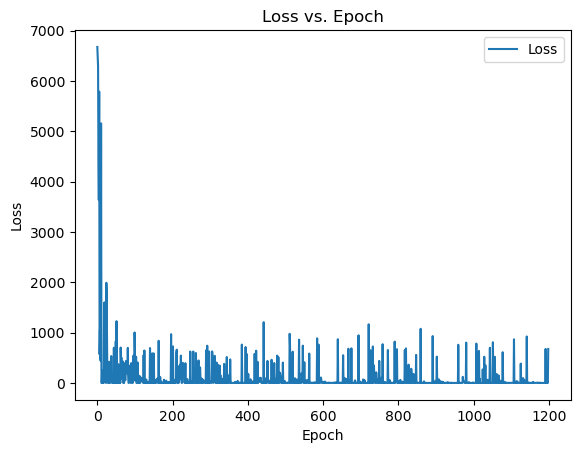

In [12]:
plt.plot(range(len(losses)), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

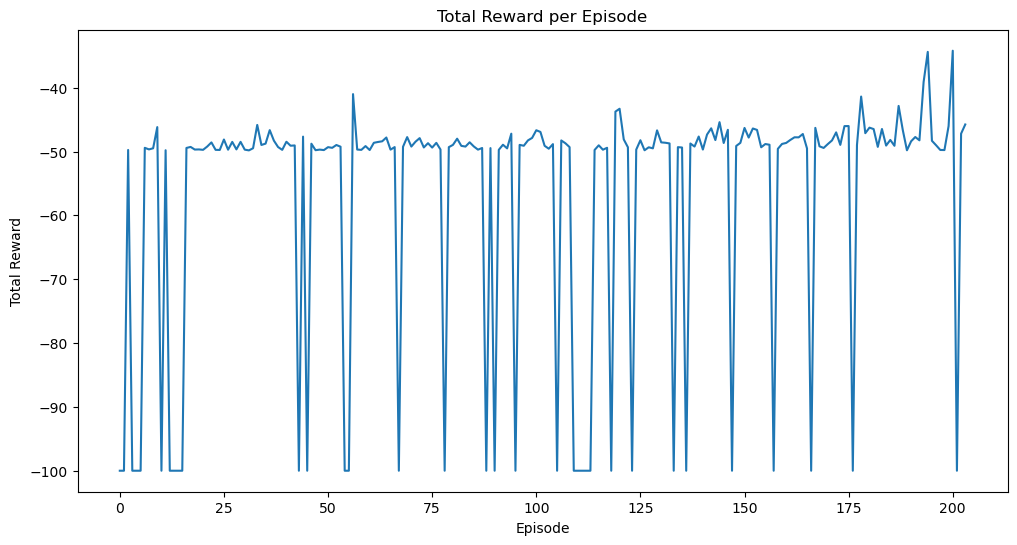

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(session_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

In [ ]:
session_rewards#.sort()
session_rewards

In [ ]:
policy = pd.DataFrame.from_dict(policy).T

In [ ]:
policy.head(60)

In [ ]:
print(policy.tail(60))

In [ ]:
network1 = tf.keras.models.load_model('Test_1.keras')
#network2 = tf.keras.models.load_model('Tester.keras')
#network3 = tf.keras.models.load_model('Testingu.keras') #14 ok
#24filter,24neuronsAll
#Best model so far for CNN

In [14]:
engine_unit = int((df_A['unit'].max() * 80 / 100) + 1)
env = CustomEnv(is_training=False)
total_returns_test=[]
ttotal_reward=0
tsession_rewards=[]

for episode in range(int(df_A['unit'].max() * 20 / 100)):
    while True:
        epsilon = 0.001
        value_fn = network.predict(np.array([state]),verbose=0)[0]
    
        if np.random.rand() < epsilon:
            action =np.random.choice(n_actions, 1)[0] 
        else:
            action = np.argmax(value_fn)
        
        next_state, reward, done, _ = env.step(action)

        done = 1 if done else 0

        ttotal_reward += reward
        state = next_state

        if done:
            #print("\nReplay: ", episode+1)
            tsession_rewards.append(ttotal_reward)
            print("Total Reward: ", ttotal_reward,"\n")
            ttotal_reward = 0
            state = env.reset()
            break

|cycle reached failure state|: 200 

Total Reward:  -100 

********|engine unit|********: 210
|cycle reached failure state|: 183 

Total Reward:  -100 

********|engine unit|********: 211
|cycle reached failure state|: 213 

Total Reward:  -100 

********|engine unit|********: 212
|cycle reached failure state|: 148 

Total Reward:  -100 

********|engine unit|********: 213
|cycle reached failure state|: 195 

Total Reward:  -100 

********|engine unit|********: 214
|cycle reached failure state|: 145 

Total Reward:  -100 

********|engine unit|********: 215
|cycle reached failure state|: 225 

Total Reward:  -100 

********|engine unit|********: 216
|cycle reached failure state|: 228 

Total Reward:  -100 

********|engine unit|********: 217
|cycle reached failure state|: 161 

Total Reward:  -100 

********|engine unit|********: 218
|cycle reached failure state|: 236 

Total Reward:  -100 

********|engine unit|********: 219
|cycle reached failure state|: 155 

Total Reward:  -100 

*

IndexError: index 266 is out of bounds for axis 0 with size 266

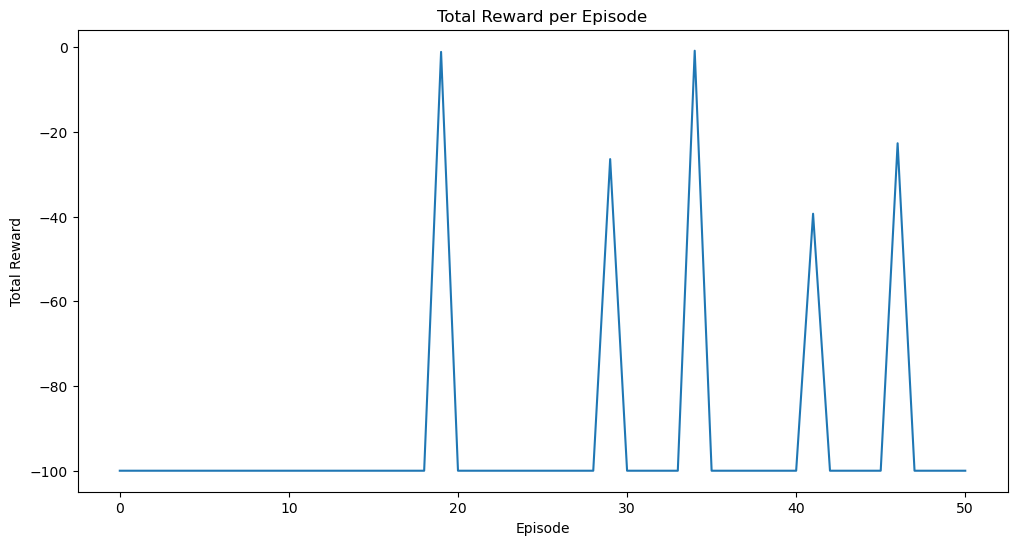

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(tsession_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

In [16]:
policy = pd.DataFrame.from_dict(policy).T
policy['remaining_cycles'] = policy['failure_state'] - policy['replace_state']
policy_test = pd.DataFrame.from_dict(policy_test).T
policy_test['remaining_cycles'] = policy_test['failure_state'] - policy_test['replace_state']

In [17]:
policy_test.head(60)

,unit,failure_state,replace_state,remaining_cycles
209,209,200,200,0
210,210,183,183,0
211,211,213,213,0
212,212,148,148,0
213,213,195,195,0
214,214,145,145,0
215,215,225,225,0
216,216,228,228,0
217,217,161,161,0
218,218,236,236,0


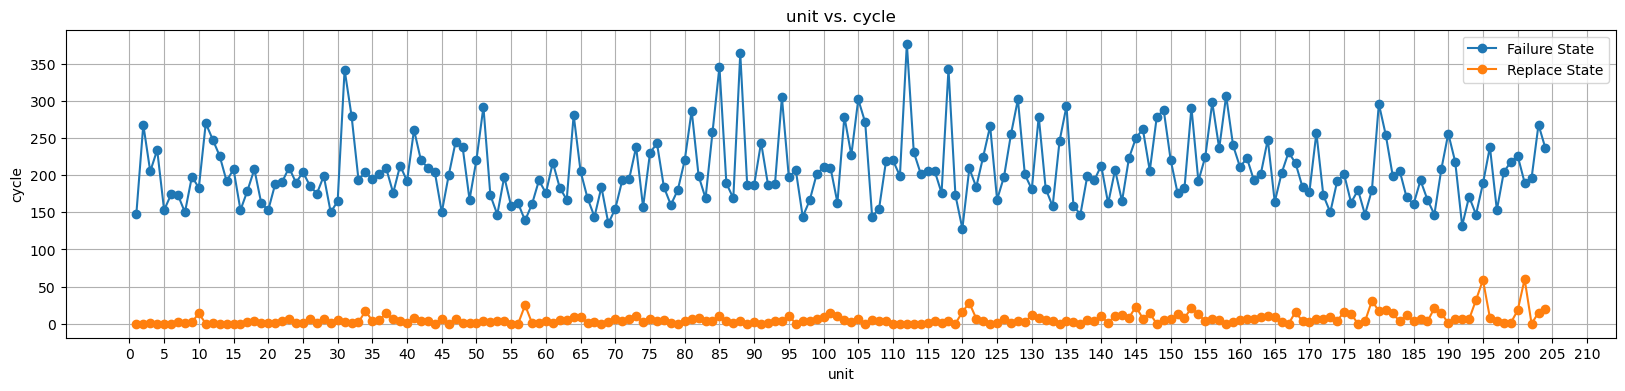

In [18]:
import matplotlib.pyplot as plt

# Plotting Training graph
plt.figure(figsize=(20, 4))
plt.plot(policy['failure_state'] , marker='o', label='Failure State')
plt.plot(policy['replace_state'], marker='o', label='Replace State')
plt.xlabel('unit')
plt.xticks(range(0, 211, 5))
plt.ylabel('cycle')
plt.title('unit vs. cycle')
plt.legend()
plt.grid(True)
plt.show()


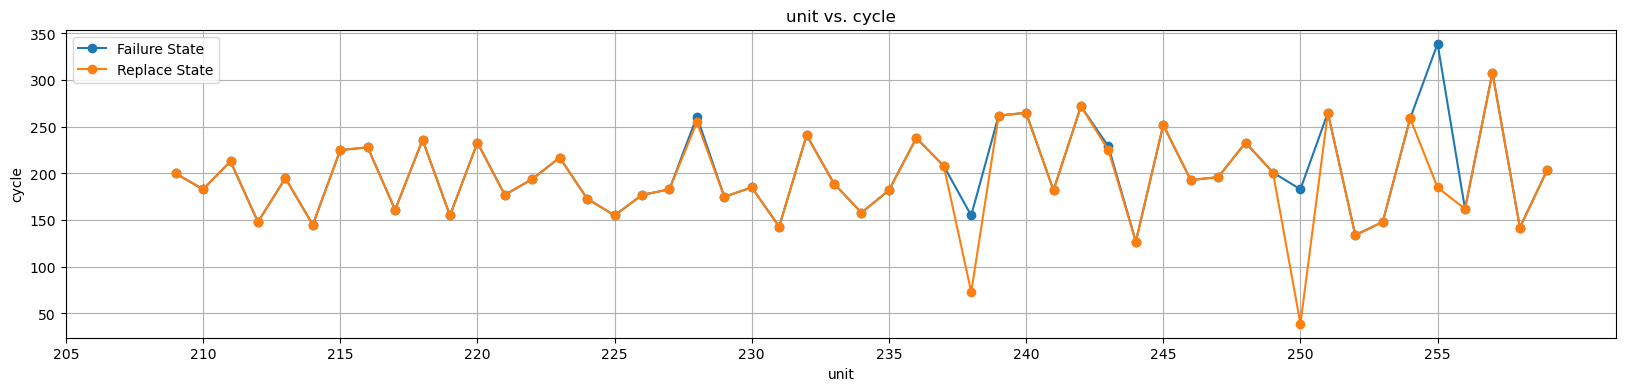

In [19]:
# Plotting Testing policy
plt.figure(figsize=(20, 4))
plt.plot(policy_test['failure_state'] , marker='o', label='Failure State')
plt.plot(policy_test['replace_state'], marker='o', label='Replace State')
plt.xlabel('unit')
plt.xticks(range(205, 260, 5))
plt.ylabel('cycle')
plt.title('unit vs. cycle')
plt.legend()
plt.grid(True)
plt.show()